In [37]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline

In [38]:
#数据读取
train_file_path = './data/training.csv'
test_file_path = './data/test.csv'

train_pd = pd.read_csv(train_file_path)
test_pd = pd.read_csv(test_file_path)
#去除含空值的行
train_pd.dropna(axis=0, how='any', inplace=True)
print(train_pd.shape)

(2140, 31)


In [39]:
from joblib import Parallel, delayed
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96, 96)
#并行处理，将图片抽取出来
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    train_img = ex(delayed(format_img)(e) for e in train_pd.Image)
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test_img = ex(delayed(format_img)(e) for e in test_pd.Image)
train_img = np.stack(train_img)[..., None]
test_img = np.stack(test_img)[..., None]
print(train_img.shape, test_img.shape)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:   13.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    7.9s


(2140, 96, 96, 1) (1783, 96, 96, 1)


[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:   11.5s finished


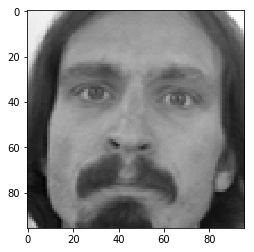

In [40]:
plt.imshow(train_img[0, :, :, 0], cmap='gray')
plt.show()

In [41]:
#获取关键点坐标
train_y = train_pd.iloc[:, :-1].values
print(train_y.shape)
print(train_y[1, :])

(2140, 30)
[64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]


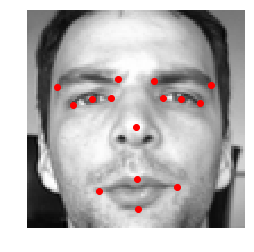

In [42]:
#将关键点和图像相融合
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        #np.vstack(np.split(y, 15))先切分成15组，再按组相连 
        #[1, 2, 3, 4,, 5, 6]=>[1, 2,],[3, 4], [5, 6]=>[[1,2], [3, 4], [5, 6]]
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color = 'red')
    plt.axis('off')
sample_idx = np.random.choice(len(train_img))
show(train_img[sample_idx], train_y[sample_idx])

In [43]:
#数据预处理
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.2, random_state=42, shuffle=True)#random_state：是随机数的种子
print(x_train.shape, x_val.shape)
print(y_val[0].shape)

(1712, 96, 96, 1) (428, 96, 96, 1)
(30,)


In [80]:
#定义模型
def model(input, is_training):
    with tf.variable_scope('layer1'):
        conv1 = tf.layers.conv2d(input, 32, 5, strides=1, padding='VALID')
        relu1 = tf.nn.relu(conv1)
        norm1 = tf.layers.batch_normalization(relu1, center=True, scale=True, training=True)
        pool1 = tf.layers.max_pooling2d(norm1, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer2'):
        conv2 = tf.layers.conv2d(pool1, 64, 5, strides=1, padding='VALID')
        relu2= tf.nn.relu(conv2)
        norm2 = tf.layers.batch_normalization(relu2, center=True, scale=True, training=True)
        pool2 = tf.layers.max_pooling2d(norm2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3'):
        conv3 = tf.layers.conv2d(pool2, 128, 2, strides=1, padding='VALID')
        relu3 = tf.nn.relu(conv3)
        norm3 = tf.layers.batch_normalization(relu3, center=True, scale=True, training=True)
        pool3 = tf.layers.max_pooling2d(norm3, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer4'):
        flatten = tf.reshape(pool3, [-1, 10*10*128])
        layer4 = tf.layers.dense(flatten, 1024)
        relu4 = tf.nn.relu(layer4)
        if is_training == True:
            relu4 = tf.layers.dropout(relu4, 0.5)
    with tf.variable_scope('layer5'):
        layer5 = tf.layers.dense(relu4, 512)
        relu5 = tf.nn.relu(layer5)
        if is_training == True:
            relu5 = tf.layers.dropout(relu5, 0.5)
    with tf.variable_scope('layer6'):
        layer6 = tf.layers.dense(relu5, 512)
        output = tf.layers.dense(layer6, 30)
    return output
#改网络https://github.com/saber1988/facial-keypoints-detection/blob/master/facial_keypoints_detection.py

In [83]:
#训练
#训练参数
BATCH_SIZE = 128
EPOCHS = 1000             #迭代次数
EARLY_STOP_PATIENCE = 100 #控制early stopping的参数

ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
y_data = tf.placeholder(tf.float32, [None, 30])
is_training = tf.placeholder(tf.bool)

out = model(x_data, is_training)
#损失函数 rsme
rmse = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_data - out), 1)))
# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    1e-3,                      # Base learning rate.
    global_step * BATCH_SIZE,  # Current index into the dataset.
    len(x_train),                # Decay step.
    0.95,                      # Decay rate.
    staircase=True)

train_step = tf.train.AdamOptimizer(learning_rate, 0.95).minimize(rmse, global_step=global_step)
#train_step = tf.train.AdamOptimizer(1e-3).minimize(rmse)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    num_batch = len(x_train) // batch_size
    remainder = len(x_train) % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if remainder > 0:
            start_index = num_batch * batch_size
            x_batch = x_train[start_index : len(x_train)-1]
            y_batch = y_train[start_index : len(x_train)-1]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss = rmse.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f" % (n, loss_step, validation_loss))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = n
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break
    saver.save(sess, ckpt_path)

数据分 13 批， 前面每批数据 128 个数据， 最后一批 48 个数据
epoch 0 train loss is 44.053318 validataion loss is 37.667793
epoch 5 train loss is 12.360391 validataion loss is 18.486355
epoch 10 train loss is 14.959503 validataion loss is 20.490421
epoch 15 train loss is 9.680051 validataion loss is 15.433530
epoch 20 train loss is 9.582685 validataion loss is 12.795540
epoch 25 train loss is 3.695004 validataion loss is 12.379227
epoch 30 train loss is 5.154501 validataion loss is 16.069447
epoch 35 train loss is 6.522840 validataion loss is 11.929421
epoch 40 train loss is 3.166208 validataion loss is 11.824767
epoch 45 train loss is 3.116422 validataion loss is 11.614373
epoch 50 train loss is 4.867287 validataion loss is 12.918159
epoch 55 train loss is 4.539910 validataion loss is 11.746202
epoch 60 train loss is 2.544441 validataion loss is 11.856401
epoch 65 train loss is 1.516245 validataion loss is 11.539282
epoch 70 train loss is 1.242768 validataion loss is 11.333311
epoch 75 train loss is 1.161373

In [56]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
    points_real = np.vstack(np.split(y_real[0], 15)).T 
    points_pred = np.vstack(np.split(y_pred[0], 15)).T 
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


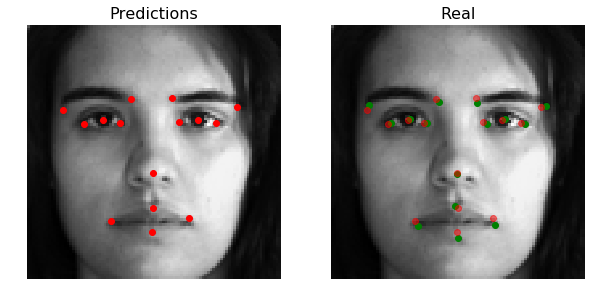

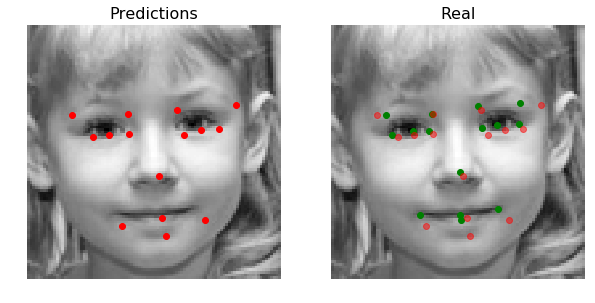

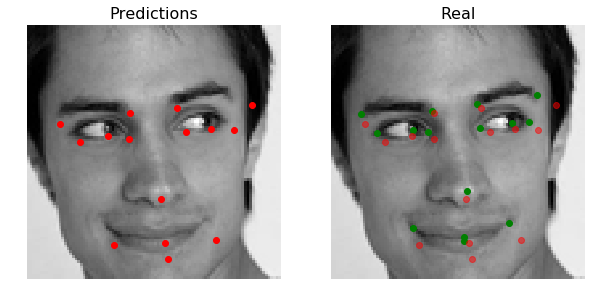

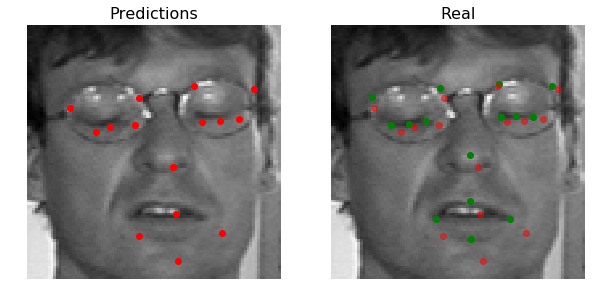

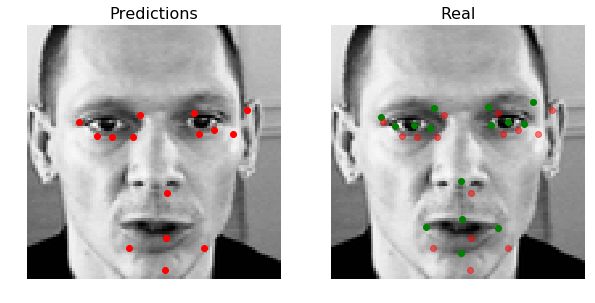

In [77]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    for i in range(5):
        idx = np.random.choice(len(x_val))
        sample_x = x_val[idx, None]#增加一维(1, 96, 96, 1) 而x_val[0]=>( 96, 96, 1)
        sample_y = y_val[idx, None]
        #sess.run(predict, feed_dict={x_val_data:sample_x, is_training:False})
        pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
        show_pred(sample_x, sample_y, pred)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


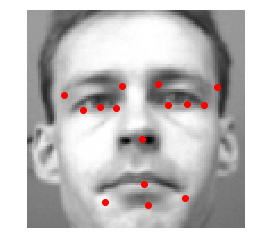

In [71]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    sample_x = test_img[3, None]
    pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
    show(test_img[3], pred[0])

In [10]:
#提交结果
keypoint_index = {
    'left_eye_center_x':0,
    'left_eye_center_y':1,
    'right_eye_center_x':2,
    'right_eye_center_y':3,
    'left_eye_inner_corner_x':4,
    'left_eye_inner_corner_y':5,
    'left_eye_outer_corner_x':6,
    'left_eye_outer_corner_y':7,
    'right_eye_inner_corner_x':8,
    'right_eye_inner_corner_y':9,
    'right_eye_outer_corner_x':10,
    'right_eye_outer_corner_y':11,
    'left_eyebrow_inner_end_x':12,
    'left_eyebrow_inner_end_y':13,
    'left_eyebrow_outer_end_x':14,
    'left_eyebrow_outer_end_y':15,
    'right_eyebrow_inner_end_x':16,
    'right_eyebrow_inner_end_y':17,
    'right_eyebrow_outer_end_x':18,
    'right_eyebrow_outer_end_y':19,
    'nose_tip_x':20,
    'nose_tip_y':21,
    'mouth_left_corner_x':22,
    'mouth_left_corner_y':23,
    'mouth_right_corner_x':24,
    'mouth_right_corner_y':25,
    'mouth_center_top_lip_x':26,
    'mouth_center_top_lip_y':27,
    'mouth_center_bottom_lip_x':28,
    'mouth_center_bottom_lip_y':29
}    

In [44]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_test_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_test_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    y_pred = []
    test_size = test_img.shape[0]
    batch_size = 1
    num_batch = test_size // batch_size
    remainder = test_size % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    for i in range(num_batch):
        x_batch = test_img[i*batch_size : (i+1)*batch_size]
        #sess.run(predict, feed_dict={x_test_data:x_batch, is_training:False})
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, is_training:False})
        y_pred.append(y_pred_batch)
    if remainder > 0:
        start_idx = num_batch * batch_size
        x_batch = test_img[start_idx : test_size-1]
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, is_training:False})
        y_pred.append(y_pred_batch)
    print("predict test image done!")
    y_pred_np = np.array(y_pred)
    y = y_pred_np.reshape(-1, 30)
    #print(y.shape)
    output_file = open("submit.csv", 'w')
    output_file.write('RowId,location\n')
    id_lookup_table = open('data/IdLookupTable.csv')
    id_lookup_table.readline()
    for line in id_lookup_table:
        RowId,ImageId,FeatureName = line.rstrip().split(',')
        image_index = int(ImageId) - 1
        feature_index = keypoint_index[FeatureName]
        feature_location = y[image_index][feature_index]
        output_file.write('{0},{1}\n'.format(RowId,feature_location))
    output_file.close()
    id_lookup_table.close()
    print('Finish!')

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
数据分 1783 批， 前面每批数据 1 个数据， 最后一批 0 个数据
predict test image done!
Finish!
